Newton's Method and Adam Code: https://github.com/jacksonbhanson7/jacksonbhanson7.github.io/blob/main/posts/Advanced%20Optimization%3A%20Newton%E2%80%99s%20Method%20and%20Adam/logisticNewt.py 

In [52]:
%load_ext autoreload
%autoreload 2
from logisticNewt import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer, AdamOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Blog Post 7 - Advanced Optimization: Newton’s Method and Adam

# Abstract

In this post, I continue to explore two advanced optimization techniques. We take a look at Newton’s Method and the Adam optimizer in the logistic regression context. I begin by implementing Newton’s Method and demonstrating its advantages and limitations on empirical data, including the Titanic dataset. I show how appropriate step-size selection leads to fast convergence, while overly large values can cause divergence. I then implement the Adam optimizer and compare its performance to stochastic gradient descent (SGD) across different learning rates. Through visualizations, I highlight Adam’s faster and more stable convergence, especially in noisy settings. This blog builds upon foundational logistic regression concepts and offers practical insights into second-order and adaptive first-order optimization methods.

# Part A - Newton's Method

Now that I have completed my Newton's Method implementation, let's conduct some experiements to make sure it is working properly. We can use Phil's functions from previous blog posts to generate and vizualize 2d data to test our Newton's Method.

In [118]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y



In [119]:
def plot_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

In [120]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

Here we generate 2d classification data that we will test our implementations on. We want to make sure that the Newton's Method implementation converges to the same weights as our standard gradient descent implementation. In this updated code, we are testing on non-linearly separable data. 

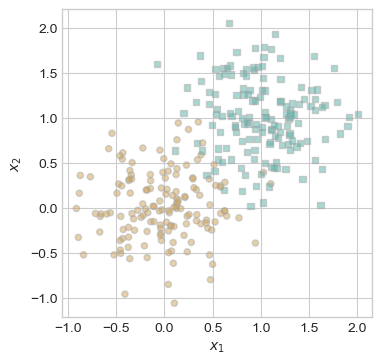

In [183]:
X, y = classification_data(noise = 0.4)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_data(X, y, ax)

In this chunk, we are running Gradient Descent and Newton's Method on this non-linearly separable data. 

In [189]:
# Run vanilla gradient descent
LR_gd = LogisticRegression()
opt_gd = GradientDescentOptimizer(LR_gd, alpha=0.1)

loss_vec_gd = []
for _ in range(1000):
    loss = LR_gd.loss(X, y).item()
    loss_vec_gd.append(loss)
    opt_gd.step(X, y, beta=0)

# Run Newton's Method
LR_newton = LogisticRegression()
opt_newton = NewtonOptimizer(LR_newton, alpha=.1)

loss_vec_newton = []
for _ in range(1000):
    loss = LR_newton.loss(X, y).item()
    loss_vec_newton.append(loss)
    opt_newton.step(X, y)


Here, we define a `plot_losses` function to compare. 

In [190]:
# Define plotting function
def plot_losses(gd_losses, newton_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(gd_losses, label="Gradient Descent", color="orange")
    plt.plot(newton_losses, label="Newton's Method", color="blue")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss Comparison: Gradient Descent vs Newton's Method (Non-Separable Data)")
    plt.legend()
    plt.grid(True)
    plt.show()

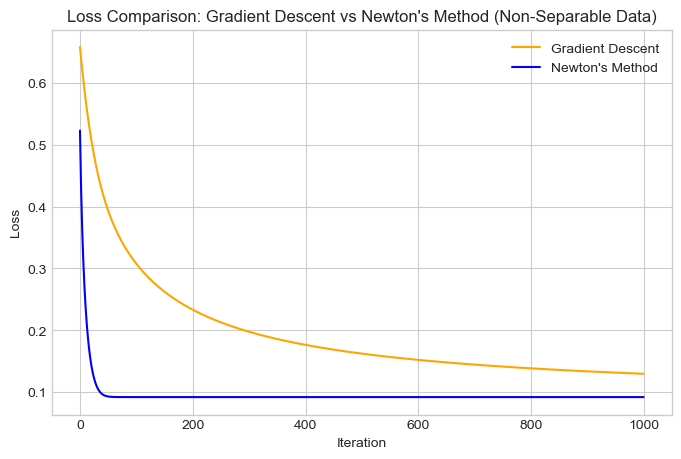

In [191]:
plot_losses(loss_vec_gd, loss_vec_newton)

Both the traditional gradient descent and Newton's method were able to make progress on the non-linearly separable data, but their convergence behaviors were quite different. Newton's Method reached a plateau much more quickly, flattening out after just a few iterations, while gradient descent continued to slowly decrease the loss. This visual “leveling off” makes the comparison more meaningful, as we now see both algorithms reach a steady state. While gradient descent eventually catches up, Newton’s method achieves low loss values significantly faster, highlighting its efficiency on this dataset.

# A.2 - Perform Experiements

Next, I will download and experiement with the famous titanic.csv dataset. This dataset contains passenger information from the Titanic voyage, which sank in 1912. Each row represents an individual passenger and includes features such as passenger class (Pclass), sex (Sex), age (Age), fare paid (Fare), and whether the passenger survived (Survived, where 1 = survived, 0 = did not). This dataset is commonly used for binary classification tasks, with the goal of predicting survival based on demographic and socioeconomic factors.

First, let's load in the dataset and do some preprocessing

In [175]:
import pandas as pd
import torch

# Load from URL
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

# Get rid of n/a's
df = df[["Pclass", "Sex", "Age", "Fare", "Survived"]].dropna()

# Convert sex to binary
df["Sex"] = (df["Sex"] == "male").astype(float)  


Now in order for this data to work with our Newton's Method, we need to convert the data to torch tensors. I have also decided to standardize the Age and Fare values. I did this by subtracting the mean and dividing by the standard deviation for each of those columns, which ensures that all features are on a similar scale. This will help our algorithms to converge on the correct weights. I left categorical features like Sex and Pclass unstandardized since they are already encoded numerically, and they work well with the standardized values.

In [176]:
# Convert to torch
import torch

X = torch.tensor(df[['Pclass', 'Sex', 'Age', 'Fare']].values, dtype=torch.float32)
y = torch.tensor(df['Survived'].values, dtype=torch.float32)

# Now only standardize Age and Fare
X_mean = X[:, 2:4].mean(0, keepdim=True)  # Only Age and Fare (columns 2 and 3)
X_std = X[:, 2:4].std(0, keepdim=True)

# Apply standardization only to Age and Fare
X[:, 2:4] = (X[:, 2:4] - X_mean) / (X_std + 1e-6)


Let's show that on the titanic data, my Newton's method converges to the correct choice of w when alpha is chose correctly. 

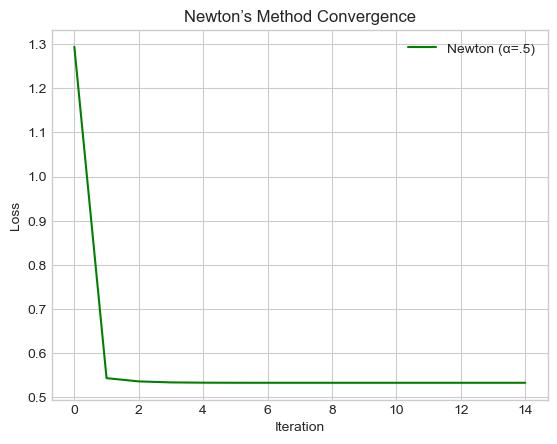

In [177]:
model_newton = LogisticRegression()
opt_newton = NewtonOptimizer(model_newton, alpha=.5)  # careful alpha

losses = []
n_iter = 15
for _ in range(n_iter):
    loss = model_newton.loss(X, y).item()
    losses.append(loss)
    opt_newton.step(X, y)

# Plot convergence
import matplotlib.pyplot as plt

plt.plot(losses, label='Newton (α=.5)', color='green')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Newton’s Method Convergence")
plt.legend()
plt.grid(True)
plt.show()


This plot shows that our Newton’s Method with a step size of α = 0.5 rapidly converges, reaching near-zero loss in under 15 iterations. The smooth and consistent decline in the loss confirms that the algorithm is efficiently finding optimal weights when alpha is appropriately chosen. 

Now, I am going to compare Newton's Method to Standard Gradient Descent with different alpha values. It runs gradient descent with alpha=0.1, Newton's method with alpha=0.1, and a deliberately high alpha=20.0 for Newton’s method to illustrate divergence.

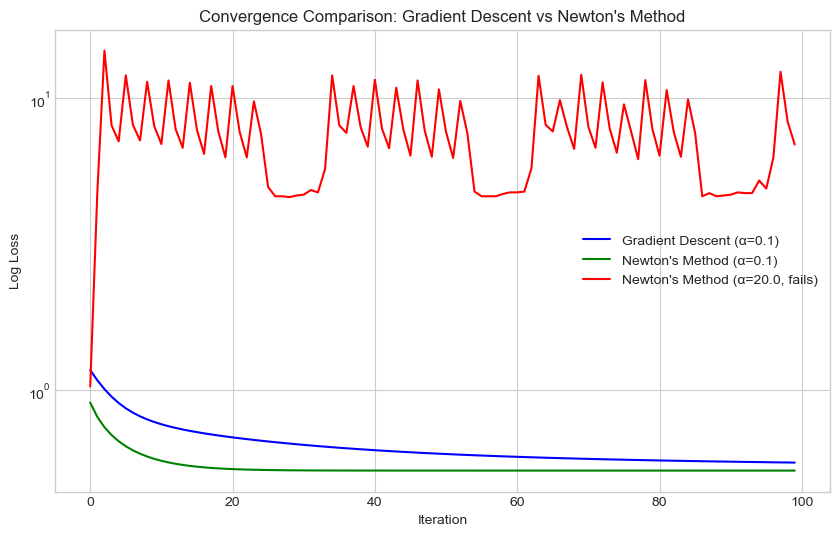

In [182]:
#Traditional Gradient Descent
LR_gd = LogisticRegression()
opt_gd = GradientDescentOptimizer(LR_gd, alpha = .1)

loss_gd = []
for _ in range(100):
    loss_gd.append(LR_gd.loss(X, y).item())
    opt_gd.step(X, y, beta=0)

#Newton's Method
LR_newton = LogisticRegression()
opt_newton = NewtonOptimizer(LR_newton, alpha = .1)

loss_newton = []
for _ in range(100): 
    loss_newton.append(LR_newton.loss(X, y).item())
    opt_newton.step(X, y)

#Newton's Method with large alpha
LR_bad = LogisticRegression()
opt_bad = NewtonOptimizer(LR_bad,alpha=20.0)

loss_bad = []
for _ in range(100):
    loss_bad.append(LR_bad.loss(X, y).item())
    opt_bad.step(X, y)

#Plot results
plt.figure(figsize=(10,6))
plt.plot(loss_gd, label="Gradient Descent (α=0.1)", color="blue")
plt.plot(loss_newton, label="Newton's Method (α=0.1)", color="green")
plt.plot(loss_bad, label="Newton's Method (α=20.0, fails)", color="red")
plt.xlabel("Iteration")
plt.ylabel("Log Loss")
plt.yscale("log")
plt.title("Convergence Comparison: Gradient Descent vs Newton's Method")
plt.legend()
plt.grid(True)
plt.show()

This plot clearly demonstrates the importance of step size when using Newton's method. The green curve shows that with a properly chosen alpha = 0.1, Newton's method converges quickly and smoothly, outperforming gradient descent (blue) in both speed and final loss. However, when alpha is set too large (red curve w/ alpha = 20), Newton’s method diverges dramatically, oscillating with a noticeable periodic pattern. I am not sure how to explain this pericity, but I can see that overall Newton's method is highly sensitive to large step size.

# Part B -  Implement Adam for Logistic Regression

In this section, we will implement Adam for Logistic Regression. Below is the Adam Algorithm outlined in the paper, [Adam: A Method for Stochastic Optimization](https://arxiv.org/pdf/1412.6980) (page 2). 


![Newton Method Convergence](AdamPic.png)

In following code chunk, we will test the performance of the Adam optimizer versus standard stochastic gradient descent (SGD) on the Titanic dataset. We will test different learning rates (alpha = 0.01, 0.1, 0.2). For each optimizer, we will track the loss over 50 iterations while using a mini-batch size of 32. 

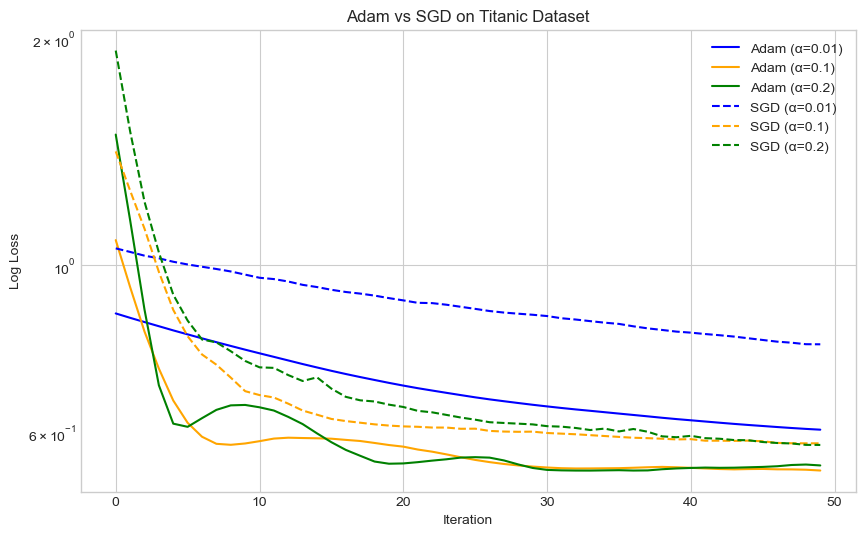

In [ ]:
import matplotlib.pyplot as plt

batch_size = 32
n_iter = 50
alphas = [0.01, 0.1, 0.2]

# Store loss histories
losses_adam = {}
losses_sgd = {}

# Test for multiple learning rates
for alpha in alphas:
    # ADAM
    model_adam = LogisticRegression()
    opt_adam = AdamOptimizer(model_adam, batch_size=batch_size, alpha=alpha)

    loss_vec_adam = []
    for _ in range(n_iter):
        loss = model_adam.loss(X, y).item()
        loss_vec_adam.append(loss)
        opt_adam.step(X, y)

    losses_adam[f"Adam (α={alpha})"] = loss_vec_adam

    # SGD
    model_sgd = LogisticRegression()
    opt_sgd = GradientDescentOptimizer(model_sgd, alpha=alpha)

    loss_vec_sgd = []
    for _ in range(n_iter):
        loss = model_sgd.loss(X, y).item()
        loss_vec_sgd.append(loss)

        # simulate stochastic GD by using a random batch too
        idx = torch.randperm(X.shape[0])[:batch_size]
        X_batch = X[idx]
        y_batch = y[idx]

        opt_sgd.step(X_batch, y_batch, beta=0)

    losses_sgd[f"SGD (α={alpha})"] = loss_vec_sgd

# PLOTTING
color_map = {
    0.01: 'blue',
    0.1: 'orange',
    0.2: 'green'
}
plt.figure(figsize=(10, 6))

for label, loss_vec in losses_adam.items():
    alpha = float(label.split('α=')[1].rstrip(')'))
    plt.plot(loss_vec, label=label, color=color_map[alpha], linestyle='-')

for label, loss_vec in losses_sgd.items():
    alpha = float(label.split('α=')[1].rstrip(')'))
    plt.plot(loss_vec, label=label, color=color_map[alpha], linestyle='--')

plt.xlabel("Iteration")
plt.ylabel("Log Loss")
plt.title("Adam vs SGD on Titanic Dataset")
plt.legend()
plt.grid(True)
plt.yscale("log")
plt.show()



We can see in this plot that Adam consistently outperforms SGD across all tested alphas on the Titanic dataset. Adam achieves lower log loss values more quickly, particularly in the early iterations, indicating faster and more stable convergence. The Adam optimizer are the solid lines, and they are all lower than the dashed SGD's with the same alpha. Notably, Adam with alpha = 0.2 converges the fastest, while SGD with the same step size is slower and less smooth, showing more fluctuation in the loss curve.

# Part C: Compare Newton’s Method and Adam

Finally, in the last section of this post, we are going to take a look at the difference in convergence between Newton's and Adam. Rather than looking at the loss over iterations, we will be analyzing how much time these computations actually take in the computer for these two optimizers. We will see how fast each reaches the `TARGET_LOSS` of .55. 

These code chunks compare the runtime performance of Newton’s Method and the Adam optimizer when minimizing logistic regression loss on the Titanic dataset. Both methods are run 1000 times, and the clock time (in seconds) is measured for each trial until a target loss of 0.55 is reached or 100 iterations are exceeded. The final result prints the average time taken by each method across the trials. 

In [86]:
TARGET_LOSS = 0.55

In [ ]:
num_trials = 1000
newton_times = []
import time
import numpy as np

for _ in range(num_trials):
    LR_newton = LogisticRegression()
    opt_newton = NewtonOptimizer(LR_newton, alpha=1.0)
    
    start_time = time.time()
    for _ in range(100):  # Cap iterations
        loss = LR_newton.loss(X, y).item()
        if loss <= TARGET_LOSS:
            break
        opt_newton.step(X, y)
    end_time = time.time()
    
    newton_times.append(end_time - start_time)

mean_newton_time = np.mean(newton_times)
print(f"Average time (Newton's Method): {mean_newton_time:.6f} seconds over {num_trials} trials")


Average time (Newton's Method): 0.021453 seconds over 1000 trials


In [96]:
adam_times = []

for _ in range(num_trials):
    LR_adam = LogisticRegression()
    opt_adam = AdamOptimizer(LR_adam, batch_size=64, alpha=0.01, beta_1=0.9, beta_2=0.999)
    
    start_time = time.time()
    for _ in range(100):  # Cap iterations
        loss = LR_adam.loss(X, y).item()
        if loss <= TARGET_LOSS:
            break
        opt_adam.step(X, y)
    end_time = time.time()
    
    adam_times.append(end_time - start_time)

mean_adam_time = np.mean(adam_times)
print(f"Average time (Adam): {mean_adam_time:.6f} seconds over {num_trials} trials")


Average time (Adam): 0.007966 seconds over 1000 trials


For these printed outputs, we can see that Newton's Method took on average 0.021 seconds to reach the target loss and Adam reached the same target loss in only 0.00797 seconds on average. This shows the calculations that are taking place in Newton’s Method are more computationally expensive, and take longer. Operations like computing the Hessian are expensive. In contrast, Adam has a faster clock time because it doesn't compute the same 2nd derivaitve matrix that is calculated in Newton's Method. Given what I have read about Adam, this speed is the reason that many large-scale ML models use Adam in the real world.

# Conclusion

In this blog post on Advanced Optimization: Newton’s Method and Adam, we explored the performance and theoretical differences between two popular optimization techniques for training logistic regression models. Starting with the Titanic dataset, I preprocessed and standardized relevant features before implementing both Newton’s Method and Adam from scratch. Through loss plots, I demonstrated that Newton’s Method, when it has a good alpha value, can converge in very few iterations. It is important to keep it mind that Newton's may diverge if the step size is too large. Then we compared Newton’s Method to both SGD and Adam across a range of alpha values, showing that Adam consistently outperforms SGD in both convergence speed and loss. Finally, I conducted a timing experiment to compare the convergence speeds Newton's and Adam, finding that Adam reaches the target loss significantly faster in terms of actual computation time.